In [2]:
import tensorflow as tf # Make sure that python interpreter is 3.9.13 Global env
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
tf.config.list_physical_devices('GPU')
pd.set_option('display.max_columns', None)

### Loading Data

In [3]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    ptb = pd.read_csv('../data/ptbxl_database.csv')
    def load_raw_data(df, sampling_rate, path):
        if(sampling_rate == 100):
            data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        else:
            data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
        return data
    
    sampling_rate=100
    # load and convert annotation data
    Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    # Load raw signal data
    X = load_raw_data(Y, 100, '../data/')

    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))


    # Apply diagnostic superclass
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [4]:
# X = X[(Y.validated_by_human == True)]
# Y = Y[(Y.validated_by_human == True)]

## Data Augmentation

### Band Pass Filter

In [5]:
import numpy as np
from scipy import signal
with tf.device('/CPU:0'):
    # Define the filter parameters
    fs = 100  # Sampling frequency (Hz)
    lowcut = 0.5  # Lower cutoff frequency (Hz)
    highcut = 40.0  # Higher cutoff frequency (Hz)
    filter_order = 4  # Filter order

    def bandpass(X, fs, lowcut, highcut, filter_order):
        # Apply bandpass filter to each channel
        filtered_data = np.zeros_like(X)
        for i in range(X.shape[2]):
            for j in range(X.shape[0]):
                b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
                filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

        # Print the shape of the filtered data
        return filtered_data

### Normalization

In [6]:
def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

### Baseline Drift Augmentation

In [7]:
import random
# Defining constant BL drift
bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

### DA Applyer

In [8]:
with tf.device('/CPU:0'):
    def da_apply(X, functions, shape = False):
        X_final = X.copy()

        # Applys DA Augments in specified order
        for func_dict in functions:
            func = func_dict['func']
            if(func_dict['params'] == None):
                X_final = func(X_final)     
            else:
                params = func_dict['params']
                X_final = func(X_final, *params)  

        if(shape == True):
            print(X_final.shape)

        return X_final

    #func_dict = [{'func': normalize, 'params': [None]}]

    #func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]


    func_dict =[{'func': normalize, 'params': [None]},
                {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
                {'func': baseline_drift, 'params': [0,0.075]}]

    X_final = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

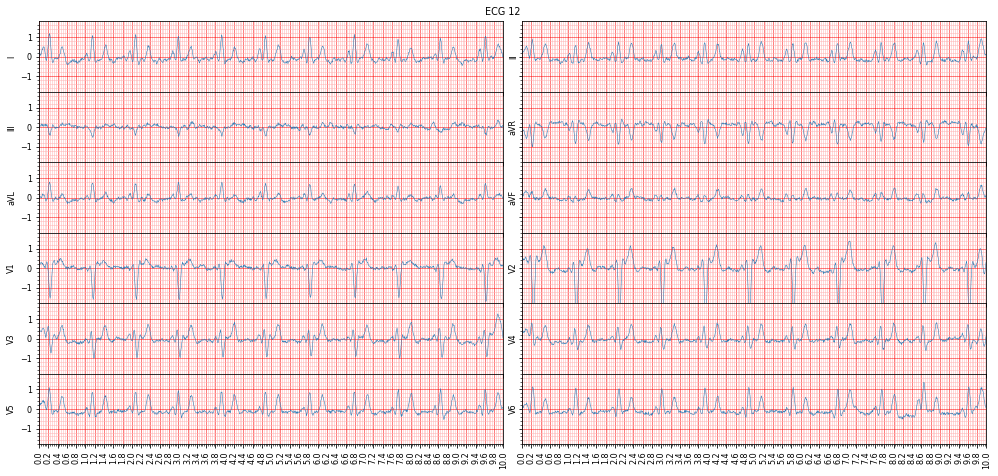

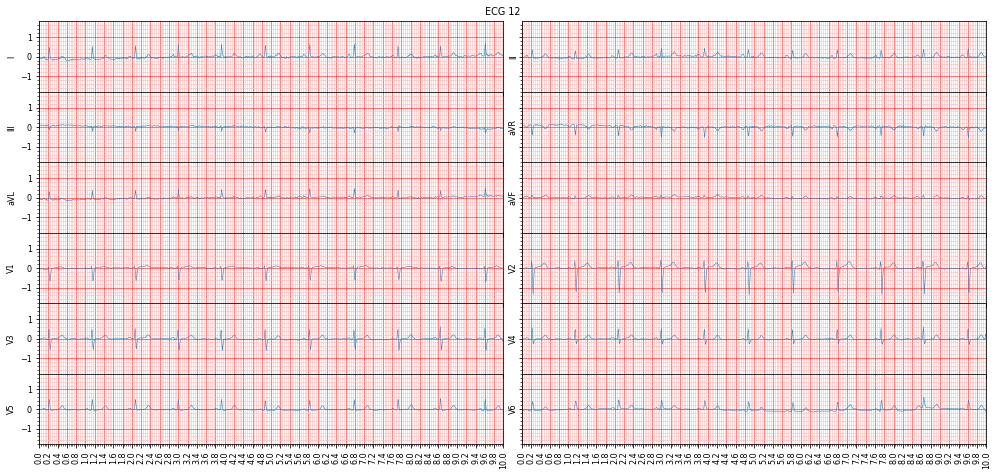

In [9]:
with tf.device('/CPU:0'):
    ecg_plot.plot_12(tf.transpose(X_final, (0,2,1))[0], sample_rate=100)
    ecg_plot.plot_12(tf.transpose(X, (0,2,1))[0], sample_rate=100)

### Splitting data into Train, Validation, Testing

In [10]:

with tf.device('/CPU:0'):
    # Split data into train and test
    test_fold =10
    val_fold = 9

    def tvt_split(X, Y, val_fold, test_fold, shape = False):
        X_train = X[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)]
        y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].sex

        X_val = X[Y.strat_fold == val_fold]
        y_val = Y[Y.strat_fold == val_fold].sex

        X_test = X[(Y.strat_fold == test_fold)]
        y_test = Y[Y.strat_fold == test_fold].sex

        y_train = pd.get_dummies(y_train)
        y_val = pd.get_dummies(y_val)
        y_test = pd.get_dummies(y_test)

        y_train = y_train.idxmax(axis = 1).to_numpy()
        y_val = y_val.idxmax(axis = 1).to_numpy()
        y_test = y_test.idxmax(axis = 1).to_numpy()

        if(shape == True):
            print((X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))

        return X_train, y_train, X_val, y_val, X_test, y_test

    X_train, y_train, X_val, y_val, X_test, y_test = tvt_split(X_final, Y, val_fold, test_fold, True)

((17418, 1000, 12), (17418,), (2183, 1000, 12), (2183,), (2198, 1000, 12), (2198,))


## Models

### Model 1

In [11]:
# Creating the model
ecg_sex_model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 7, strides = 4, padding = "valid", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 48, kernel_size = 6, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=3, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 96, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.Dropout(0.2, seed = 13),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model
ecg_sex_model_1.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                      metrics = ['accuracy'])


# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)



# Fitting the model
#history_4 = ecg_sex_model_1.fit(X_train, y_train, epochs = 15, validation_data = (X_test, y_test))

### Model 2

In [12]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Batching
batch_size = 16
num_epochs = 15
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(X_train))
dataset = dataset.batch(batch_size)

# Creating the model
ecg_sex_model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 4, padding = "valid", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 7, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=1, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 96, kernel_size = 5, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=1, strides = 1, padding = "valid"),


    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(64, activation= 'relu', kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model
ecg_sex_model_2.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0003),
                      metrics = ['accuracy'])


# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True)



# Fitting the model
history_6 = ecg_sex_model_2.fit(dataset, epochs = num_epochs, validation_data = (X_val, y_val), callbacks = checkpoint_callback)

Epoch 1/15
1089/1089 [==============================] - 20s 16ms/step - loss: 4.2474 - accuracy: 0.7158 - val_loss: 0.7149 - val_accuracy: 0.7641
Epoch 2/15
1089/1089 [==============================] - 18s 16ms/step - loss: 0.7104 - accuracy: 0.7741 - val_loss: 0.6737 - val_accuracy: 0.7934
Epoch 3/15
1089/1089 [==============================] - 19s 17ms/step - loss: 0.6901 - accuracy: 0.7831 - val_loss: 0.6394 - val_accuracy: 0.7879
Epoch 4/15
1089/1089 [==============================] - 20s 18ms/step - loss: 0.6696 - accuracy: 0.7913 - val_loss: 0.6417 - val_accuracy: 0.7925
Epoch 5/15
1089/1089 [==============================] - 18s 17ms/step - loss: 0.6503 - accuracy: 0.7975 - val_loss: 0.6912 - val_accuracy: 0.7664
Epoch 6/15
1089/1089 [==============================] - 18s 17ms/step - loss: 0.6388 - accuracy: 0.8022 - val_loss: 0.6366 - val_accuracy: 0.7916
Epoch 7/15
1089/1089 [==============================] - 19s 17ms/step - loss: 0.6256 - accuracy: 0.8119 - val_loss: 0.6275 -

### Model 3

In [13]:

tf.debugging.disable_traceback_filtering

# Batching
batch_size = 64
num_epochs = 20
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(X_train))
dataset = dataset.batch(batch_size)


# Creating the model
ecg_sex_model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 16, kernel_size = 7, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 16, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 12, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed = 13),


    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model
ecg_sex_model_3.compile(loss = tf.keras.losses.mse,
                    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0003),
                    metrics = ['mae'])


# Call Backs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True)


# Train the model

#ecg_sex_model_3.fit(dataset, epochs = num_epochs, validation_data = (X_val, y_val))

## Performance

### Visualizing Performance

In [14]:
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb 
import itertools

figsize = (10, 10)

def make_confusion_matrix(X_test, y_test, classes, model, figsize=(18,18), text_size = 15):
    # Create the confusion matrix
    y_prob = model.predict(X_test)
    y_pred =np.squeeze(np.where(y_prob >= 0.5, 1, 0))
    cm = confusion_matrix(y_test, tf.round(y_pred))
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0]

    # Let's prettify it
    fig, ax = plt.subplots(figsize=figsize)
    # Create a matrix plot
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
    fig.colorbar(cax)

    # Create classes
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title=(str(model.name) + " for Confusion Matrix"),
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

    # Set x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Adjust label size
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)

    # Set threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=10)

69/69 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.8204


[0.6835418343544006, 0.8204305768013]

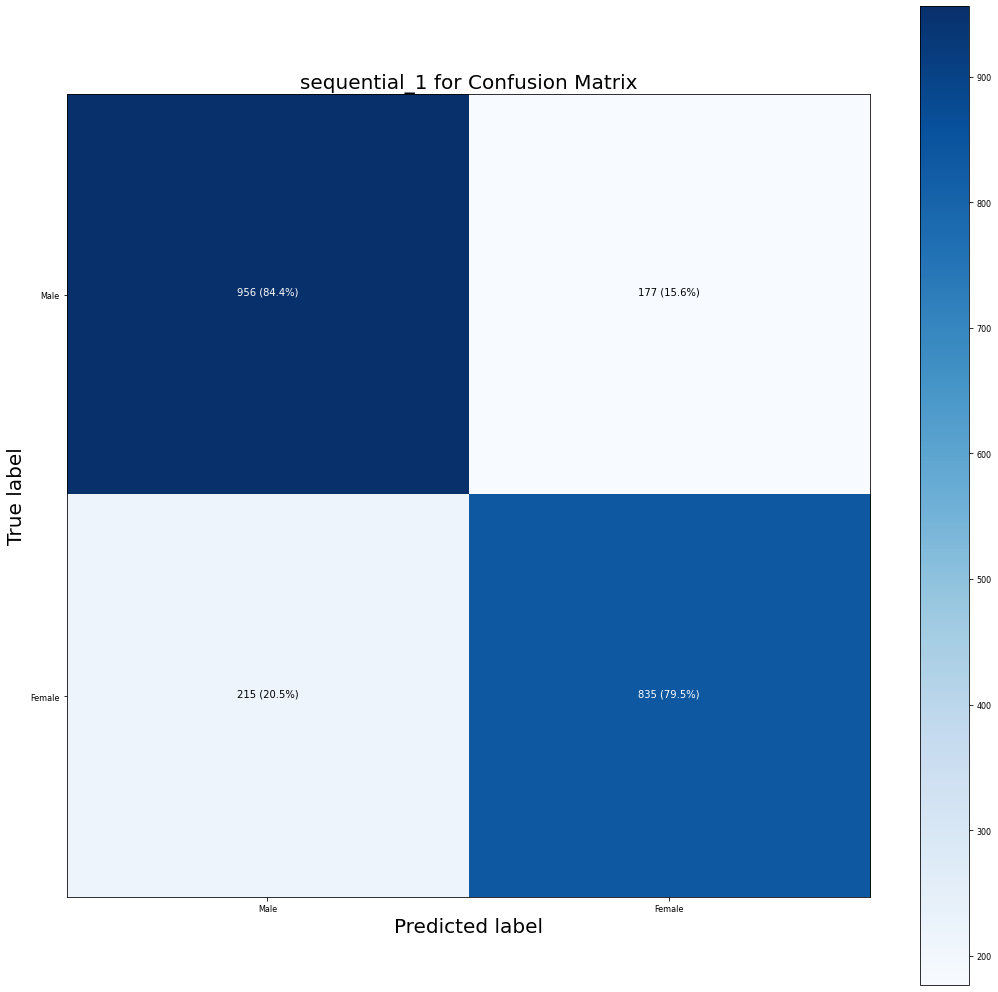

In [18]:
class_name = ['Male', 'Female']
make_confusion_matrix(X_val, y_val, model = ecg_sex_model_2, classes = class_name)
ecg_sex_model_2.evaluate(X_val, y_val)

69/69 [==============================] - 0s 3ms/step


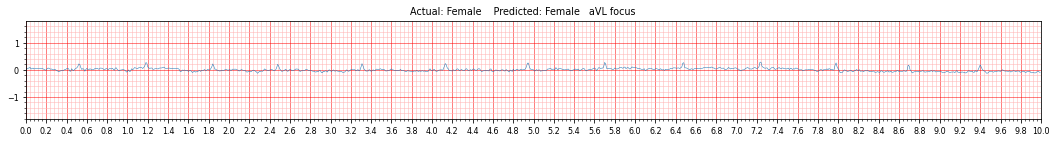

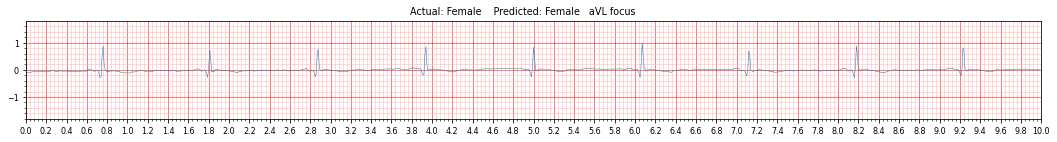

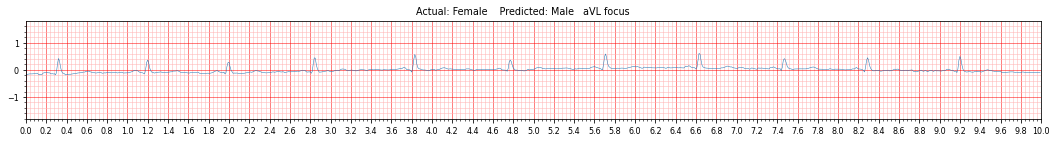

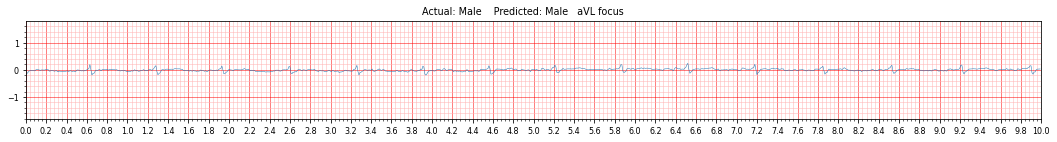

In [19]:
from random import choice

def visualize(y_test, X_test, model):
    class_names  = ['Male', 'Female']
    y_prob = model.predict(X_test)
    y_pred =np.squeeze(np.where(y_prob >= 0.5, 1, 0))
    for i in range(4):
        ind = choice(range(1, len(X_test)))
        plot_title = ("Actual: " + class_names[y_test[ind]] + "    Predicted: " + class_names[y_pred[ind]])
        ecg_plot.plot_1(tf.transpose(X, (0,2,1))[ind][4], sample_rate=100, title = plot_title + "   aVL focus")

visualize(y_test, X_test, ecg_sex_model_2)